# WTTE-RNN in keras
A template to use with data of varying shape (but fixed sequence length for now). This notebook imports from wtte-rnn repo. See `standalone_simple_example.ipynb` for a similar notebook with all functions inlined.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense

from keras.layers import LSTM,GRU
from keras.layers import Lambda
from keras.layers.wrappers import TimeDistributed

from keras.optimizers import RMSprop,adam
from keras.callbacks import History, TensorBoard

import wtte.weibull as weibull
import wtte.wtte as wtte


Using Theano backend.


In [2]:
def get_data(n_timesteps, every_nth,n_repeats,noise_level,n_features,use_censored = True):
    def get_equal_spaced(n, every_nth):
        # create some simple data of evenly spaced events recurring every_nth step
        # Each is on (time,batch)-format
        events = np.array([np.array(xrange(n)) for _ in xrange(every_nth)])
        events = events + np.array(xrange(every_nth)).reshape(every_nth, 1) + 1

        tte_actual = every_nth - 1 - events % every_nth

        was_event = (events % every_nth == 0) * 1.0
        was_event[:, 0] = 0.0

        events = tte_actual == 0

        is_censored = (events[:, ::-1].cumsum(1)[:, ::-1] == 0) * 1
        tte_censored = is_censored[:, ::-1].cumsum(1)[:, ::-1] * is_censored
        tte_censored = tte_censored + (1 - is_censored) * tte_actual

        events = np.copy(events.T * 1.0)
        tte_actual = np.copy(tte_actual.T * 1.0)
        tte_censored = np.copy(tte_censored.T * 1.0)
        was_event = np.copy(was_event.T * 1.0)
        not_censored = 1 - np.copy(is_censored.T * 1.0)

        return tte_censored, not_censored, was_event, events, tte_actual
    
    tte_censored,not_censored,was_event,events,tte_actual = get_equal_spaced(n=n_timesteps,every_nth=every_nth)

    # From https://keras.io/layers/recurrent/
    # input shape rnn recurrent if return_sequences: (nb_samples, timesteps, input_dim)

    u_train      = not_censored.T.reshape(n_sequences,n_timesteps,1)
    x_train      = was_event.T.reshape(n_sequences,n_timesteps,1)
    tte_censored = tte_censored.T.reshape(n_sequences,n_timesteps,1)
    y_train      = np.append(tte_censored,u_train,axis=2) # (n_sequences,n_timesteps,2)

    u_test       = np.ones(shape=(n_sequences,n_timesteps,1))
    x_test       = np.copy(x_train)
    tte_actual   = tte_actual.T.reshape(n_sequences,n_timesteps,1)
    y_test       = np.append(tte_actual,u_test,axis=2) # (n_sequences,n_timesteps,2)

    if not use_censored:
        x_train = np.copy(x_test)
        y_train = np.copy(y_test)
    # Since the above is deterministic perfect fit is feasible. 
    # More noise->more fun so add noise to the training data:
    
    x_train = np.tile(x_train.T,n_repeats).T
    y_train = np.tile(y_train.T,n_repeats).T

    # Try with more than one feature TODO
    x_train_new = np.zeros([x_train.shape[0],x_train.shape[1],n_features])
    x_test_new = np.zeros([x_test.shape[0],x_test.shape[1],n_features])
    for f in xrange(n_features):
        x_train_new[:,:,f] = x_train[:,:,0]
        x_test_new[:,:,f]  = x_test[:,:,0]
        
    x_train = x_train_new
    x_test  = x_test_new
    
    # xtrain is signal XOR noise with probability noise_level
    noise = np.random.binomial(1,noise_level,size=x_train.shape)
    x_train = x_train+noise-x_train*noise
    return y_train,x_train, y_test,x_test,events


test shape (80, 200, 1) (80, 200, 2)


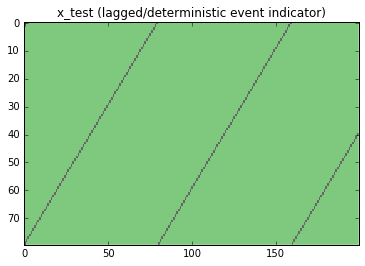

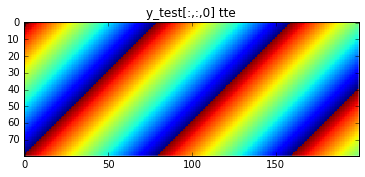

train shape (80000, 200, 1) (80000, 200, 2)


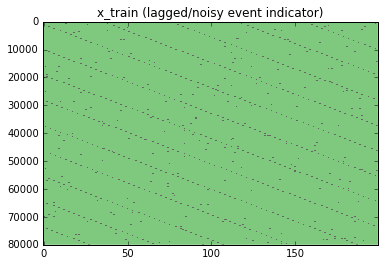

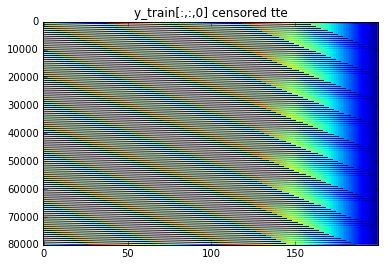

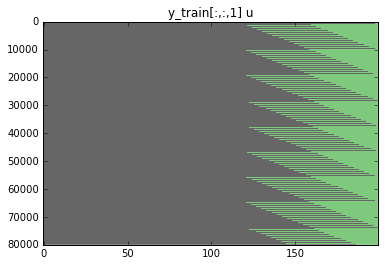

In [3]:
n_timesteps    = 200
n_sequences = every_nth = 80
n_features = 1
n_repeats = 1000
noise_level = 0.005
use_censored = True

y_train,x_train, y_test,x_test,events = get_data(n_timesteps, every_nth,n_repeats,noise_level,n_features,use_censored)

print 'test shape',x_test.shape,y_test.shape
plt.imshow(x_test[:,:,:].sum(axis=2)>0,interpolation="none",cmap='Accent',aspect='auto')
plt.title('x_test (lagged/deterministic event indicator)')
plt.show()
plt.imshow(y_test[:,:,0],interpolation="none")
plt.title('y_test[:,:,0] tte')
plt.show()

print 'train shape',x_train.shape,y_train.shape
# (might look like the pattern is different but set n_repeats 
#  lower and you'll see that it's the same):
plt.imshow(x_train[:,:,:].sum(axis=2)>0,interpolation="none",cmap='Accent',aspect='auto')
plt.title('x_train (lagged/noisy event indicator)')
plt.show()
plt.imshow(y_train[:,:,0],interpolation="none",aspect='auto')
plt.title('y_train[:,:,0] censored tte')
plt.show()
plt.imshow(y_train[:,:,1],interpolation="none",cmap='Accent',aspect='auto')
plt.title('y_train[:,:,1] u')
plt.show()


In [4]:
# ## SANITY CHECK: Use pure Weibull data censored at C(ensoring point). 
# ## Should converge to the generating A(alpha) and B(eta) for each timestep
# def generate_data(A,B,C,shape,discrete_time):
#     # Generate Weibull random variables
#     W = np.sort(A*np.power(-np.log(np.random.uniform(0,1,shape)),1/B))
    
#     if discrete_time:
#         C = np.floor(C)
#         W = np.floor(W)

#     U = np.less_equal(W, C)*1
#     Y = np.minimum(W,C)    
#     return W,Y,U

# n_sequences = 10000
# n_timesteps = 100
# n_features = 1

# y_test,y_train,u_train = generate_data(A=1000.,
#                                        B=2.,
#                                        C=1000./2, # <np.inf -> impose censoring
#                                        shape=[n_sequences,n_timesteps,n_features],
#                                        discrete_time=True)
# x_train = x_test = np.ones_like(y_train)

# y_test   = np.append(y_test,np.ones_like(y_test),axis=-1)
# y_train  = np.append(y_train,u_train,axis=-1)

# xlim_temp = y_test[:,:,0].max()
# plt.hist(y_test[:,:,0].flatten(),bins=100)
# plt.xlim(0,xlim_temp)
# plt.title('actual tte')
# plt.show()
# plt.hist(y_train[:,:,0].flatten(),bins=100)
# plt.title('censored tte')
# plt.xlim(0,xlim_temp)
# plt.show()
# print y_test.shape
# print y_train.shape

## Things to try out:
    * have fun with data paramaters:
        * every_nth to control event frequency
        * noise_level to make it more noisy
        * n_timesteps 
        * n_features to get more noisy input
    * Generate more interesting temporal relationships
    * Here we use the smallest possible GRU. Try different learning rates, network architectures, initializations. 
    * Try Implementing multivariate distributions. 
    * Invent better output activation layer
    * Please create some nice way to use variable length sequences.

In [5]:
# Prep. output activation layer.
# Start at naive geometric (beta=1) MLE:
tte_mean_train = np.nanmean(y_train[:,:,0])
init_alpha = -1.0/np.log(1.0-1.0/(tte_mean_train+1.0) )
init_alpha = init_alpha/np.nanmean(y_train[:,:,1]) # use if lots of censoring
print 'init_alpha: ',init_alpha

np.random.seed(1)
# Store some history
history = History()

# Start building the model
model = Sequential()
#model.add(TimeDistributed(Dense(2), input_shape=(None, n_features)))
model.add(GRU(1, input_shape=(n_timesteps, n_features),activation='tanh',return_sequences=True))

model.add(Dense(2))
model.add(Lambda(wtte.output_lambda, arguments={"init_alpha":init_alpha, 
                                               "max_beta_value":4.0}))
loss = wtte.loss(kind='discrete').loss_function

model.compile(loss=loss, optimizer=adam(lr=.01))

model.summary()

init_alpha:  43.4425042957


/usr/local/lib/python2.7/site-packages/keras/layers/core.py:640: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 200, 2)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 200, 1)            9         
_________________________________________________________________
dense_1 (Dense)              (None, 200, 2)            4         
_________________________________________________________________
lambda_1 (Lambda)            (None, 200, 2)            0         
Total params: 13.0
Trainable params: 13.0
Non-trainable params: 0.0
_________________________________________________________________


In [6]:
# Fit! (really don't need to train this long)
np.random.seed(1)
model.fit(x_train, y_train,
          epochs=80, 
          batch_size=x_train.shape[0]/10, 
          verbose=2, 
          validation_data=(x_test, y_test),
          callbacks=[history],
#          callbacks=[history,tensorboard]
          )

Train on 80000 samples, validate on 80 samples
Epoch 1/80
11s - loss: 3.8191 - val_loss: 4.6541
Epoch 2/80
10s - loss: 3.7907 - val_loss: 4.6171
Epoch 3/80
10s - loss: 3.7663 - val_loss: 4.5857
Epoch 4/80
10s - loss: 3.7485 - val_loss: 4.5637
Epoch 5/80
11s - loss: 3.7397 - val_loss: 4.5530
Epoch 6/80
10s - loss: 3.7370 - val_loss: 4.5486
Epoch 7/80
10s - loss: 3.7348 - val_loss: 4.5456
Epoch 8/80
11s - loss: 3.7319 - val_loss: 4.5434
Epoch 9/80
10s - loss: 3.7292 - val_loss: 4.5401
Epoch 10/80
10s - loss: 3.7262 - val_loss: 4.5355
Epoch 11/80
11s - loss: 3.7228 - val_loss: 4.5310
Epoch 12/80
10s - loss: 3.7186 - val_loss: 4.5244
Epoch 13/80
11s - loss: 3.7122 - val_loss: 4.5136
Epoch 14/80
11s - loss: 3.6993 - val_loss: 4.4881
Epoch 15/80
10s - loss: 3.6839 - val_loss: 4.4622
Epoch 16/80
10s - loss: 3.6594 - val_loss: 4.4207
Epoch 17/80
10s - loss: 3.6177 - val_loss: 4.3189
Epoch 18/80
11s - loss: 3.5588 - val_loss: 4.2009
Epoch 19/80
11s - loss: 3.5093 - val_loss: 4.1475
Epoch 20/80


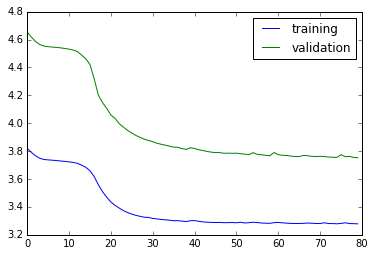

In [7]:
plt.plot(history.history['loss'],    label='training')
plt.plot(history.history['val_loss'],label='validation')
plt.legend()

# Predictions
Try out training the model with different levels of noise. With more noise confidence gets lower (smaller beta). With less noise beta goes to maximum value and the predicted mode/peak probability is centered around the actual TTE.

All test cases (no noise)
(each horizontal line is a sequence)


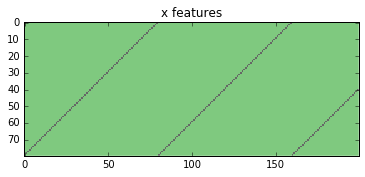

(80, 200, 2)


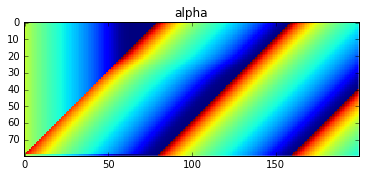

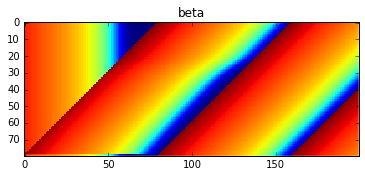

Some training cases (noisy features)
(80, 200, 2)


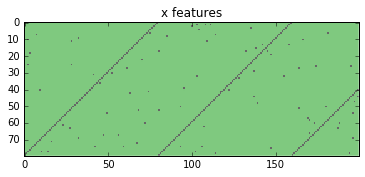

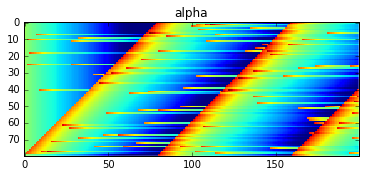

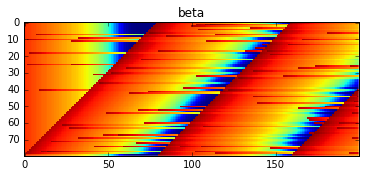

In [8]:
# Make some parametric predictions
print 'All test cases (no noise)'
print '(each horizontal line is a sequence)'
predicted = model.predict(x_test)
plt.imshow(x_test[:every_nth,:,:].sum(axis=2)>0,interpolation="none",cmap='Accent')
plt.title('x features')
plt.show()
print(predicted.shape)
plt.imshow(predicted[:,:,0],interpolation="none")
plt.title('alpha')
plt.show()
plt.imshow(predicted[:,:,1],interpolation="none")
plt.title('beta')
plt.show()

print 'Some training cases (noisy features)'
predicted = model.predict(x_train[:every_nth,:,:])
print(predicted.shape)
plt.imshow(x_train[:every_nth,:,:].sum(axis=2)>0,interpolation="none",cmap='Accent')
plt.title('x features')
plt.show()
plt.imshow(predicted[:,:,0],interpolation="none")
plt.title('alpha')
plt.show()
plt.imshow(predicted[:,:,1],interpolation="none")
plt.title('beta')
plt.show()


one training case:


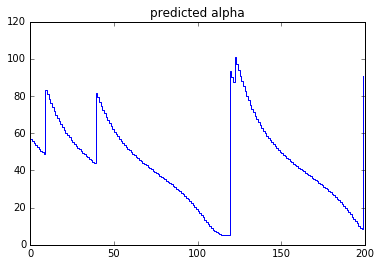

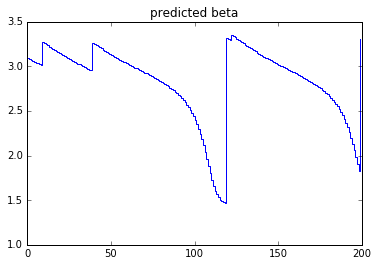

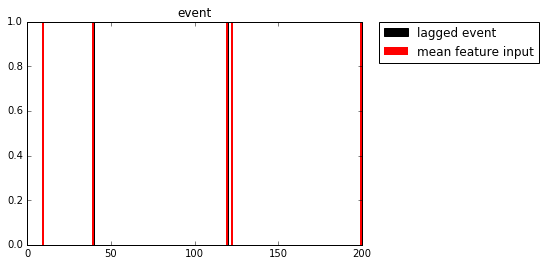

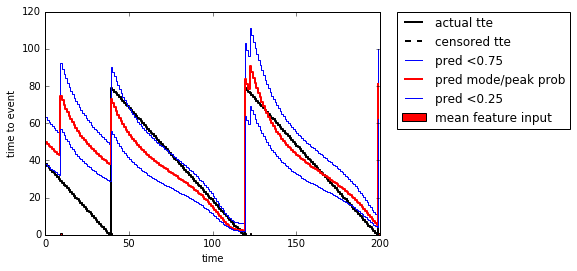

In [9]:
# TTE, Event Indicator, Alpha, Beta
drawstyle = 'steps-post'

print 'one training case:'
batch_indx =every_nth/2
a = predicted[batch_indx,:,0]
b = predicted[batch_indx,:,1]
this_x_train = x_train[batch_indx,:,:].mean(axis=1)
this_x_test =  x_test[batch_indx,:,:].mean(axis=1)

this_tte_train = y_train[batch_indx,:,0]
this_tte_test =  y_test[batch_indx,:,0]

plt.plot(a,drawstyle='steps-post')
plt.title('predicted alpha')
plt.show()
plt.plot(b,drawstyle='steps-post')
plt.title('predicted beta')
plt.show()

plt.bar(xrange(n_timesteps),this_x_test,color='black', label='lagged event')
plt.bar(xrange(n_timesteps),this_x_train,color='red',linewidth=0,label='mean feature input')
plt.title('event')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.plot(this_tte_test ,label='actual tte',color='black',linewidth=2,drawstyle=drawstyle)
plt.plot(this_tte_train,label='censored tte',color='black',linestyle='dashed',linewidth=2,drawstyle=drawstyle)

plt.plot(weibull.quantiles(a,b,0.75),color='blue',label='pred <0.75',drawstyle=drawstyle)
plt.plot(weibull.mode(a, b), color='red',linewidth=2,label='pred mode/peak prob',drawstyle=drawstyle)
#plt.plot(weibull.mean(a, b), color='green',linewidth=1,label='pred mean',drawstyle='steps-post')
plt.plot(weibull.quantiles(a,b,0.25),color='blue',label='pred <0.25',drawstyle=drawstyle)
plt.xlabel('time')
plt.ylabel('time to event')
plt.bar(xrange(n_timesteps),this_x_train,color='red',label='mean feature input')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [10]:
# ## BONUS : How to make a gif:
# predicted = model.predict(x_train[:(2*every_nth),:,:])

# print 'one training case:'
# for batch_indx in xrange(78,predicted.shape[0]):
#     a = predicted[batch_indx,:,0]
#     b = predicted[batch_indx,:,1]
#     this_x_train = x_train[batch_indx,:,:].mean(axis=1)
#     this_x_test =  x_test[batch_indx%every_nth,:,:].mean(axis=1)

#     this_tte_train = y_train[batch_indx,:,0]
#     this_tte_test =  y_test[batch_indx%every_nth,:,0]
    
#     fig_scale = 0.8
#     fig, ax = plt.subplots(2, sharex=False, figsize=(fig_scale*6.5, fig_scale*6.5))

#     ax[0].bar(xrange(n_timesteps),this_x_test,color='black', label='lagged event')
#     ax[0].bar(xrange(n_timesteps),this_x_train,color='red',linewidth=0,label='feature input')
#     ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
#     ax[1].plot(this_tte_test ,label='actual tte',color='black',linewidth=2,drawstyle='steps-post')
#     ax[1].plot(this_tte_train,label='censored tte',color='black',linestyle='dashed',linewidth=2,drawstyle='steps-post')

#     ax[1].plot(tte.weibull_quantiles(a,b,0.75),color='blue',label='pred <0.75',drawstyle='steps-post')
#     ax[1].plot(tte.weibull_mode(a, b), color='red',linewidth=2,label='pred. mode',drawstyle='steps-post')
#     ax[1].plot(tte.weibull_quantiles(a,b,0.25),color='blue',label='pred <0.25',drawstyle='steps-post')
#     ax[1].set_xlabel('time')
#     ax[1].set_ylabel('time to event')
#     ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#     fig_name = './gifs/'+format(batch_indx,'05d')
#     fig.savefig(fig_name,bbox_inches='tight',transparent=False,dpi=75)
#     plt.close()
#     print fig_name

# ### imagagemagick : 
# ## cd ./gif;
# ## convert -delay 12 -verbose -deconstruct -layers optimize -loop 0  *.png evenly_spaced.gif;